In [1]:
#Bibliotecas Utilizadas
import pandas as pd
import pickle
import shap
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score,classification_report, roc_curve
from sklearn.model_selection import train_test_split
import os
import mlflow
import catboost
import matplotlib.pyplot as plt
from boruta import BorutaPy

Encaminhamento: juntar as varipavies TRAT_SUPER com TRATSUP_AT?

## Importação

In [2]:
#Melhor modelo
nome_do_experimento = "ML_Modelagem_sudeste"
runs_df = mlflow.search_runs(experiment_names=[nome_do_experimento], order_by=["metrics.AUC DESC"])
best_run = runs_df.iloc[0]
best_run_id = best_run.run_id
model_name = best_run["tags.modelo"]
model_auc = best_run["metrics.AUC"]
print(f"Melhor modelo encontrado: {model_name} com AUC de {model_auc:.4f} (Run ID: {best_run_id})")

#Construindo a URI e carregando o modelo no seu "sabor" nativo
model_uri = f"runs:/{best_run_id}/{model_name}"       
flavor_module = getattr(mlflow, model_name.lower())
best_model_native = flavor_module.load_model(model_uri)
print(f"Modelo nativo ({type(best_model_native)}) carregado com sucesso!")

Melhor modelo encontrado: CatBoost com AUC de 0.8017 (Run ID: ae9e2130c490418287bcb71279db6563)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!


In [3]:
# Importar dados
# 1. Especifique o caminho para a pasta onde seus arquivos CSV estão localizados.
caminho_da_pasta = 'dados/train_test'

# Cria um dicionário vazio para armazenar os DataFrames
dados = {}

# Lista todos os arquivos na pasta especificada
try:
    lista_de_arquivos = os.listdir(caminho_da_pasta)

    # Itera sobre cada arquivo encontrado na pasta
    for arquivo in lista_de_arquivos:
        # Verifica se o arquivo é um .csv
        if arquivo.endswith('.csv'):
            # Cria o nome da "variável" (que será a chave do dicionário) removendo a extensão .csv
            nome_variavel = os.path.splitext(arquivo)[0]
            
            # Constrói o caminho completo para o arquivo
            caminho_completo = os.path.join(caminho_da_pasta, arquivo)
            
            # Carrega o arquivo CSV e o armazena no dicionário
            dados[nome_variavel] = pd.read_csv(caminho_completo)
            
            print(f"Arquivo '{arquivo}' carregado com sucesso em dados['{nome_variavel}']")

except FileNotFoundError:
    print(f"Erro: O diretório não foi encontrado em '{caminho_da_pasta}'.")
    print("Por favor, verifique se o caminho está correto e tente novamente.")

Arquivo 'X_test_centro_oeste.csv' carregado com sucesso em dados['X_test_centro_oeste']
Arquivo 'X_test_nordeste.csv' carregado com sucesso em dados['X_test_nordeste']
Arquivo 'X_test_norte.csv' carregado com sucesso em dados['X_test_norte']
Arquivo 'X_test_sudeste.csv' carregado com sucesso em dados['X_test_sudeste']
Arquivo 'X_test_sul.csv' carregado com sucesso em dados['X_test_sul']
Arquivo 'X_train_centro_oeste.csv' carregado com sucesso em dados['X_train_centro_oeste']
Arquivo 'X_train_nordeste.csv' carregado com sucesso em dados['X_train_nordeste']
Arquivo 'X_train_norte.csv' carregado com sucesso em dados['X_train_norte']
Arquivo 'X_train_sudeste.csv' carregado com sucesso em dados['X_train_sudeste']
Arquivo 'X_train_sul.csv' carregado com sucesso em dados['X_train_sul']
Arquivo 'y_test_centro_oeste.csv' carregado com sucesso em dados['y_test_centro_oeste']
Arquivo 'y_test_nordeste.csv' carregado com sucesso em dados['y_test_nordeste']
Arquivo 'y_test_norte.csv' carregado com s

## Modelo Sudeste -> Regiões

In [ ]:
regioes_alvo = ['nordeste', 'norte', 'centro_oeste', 'sul']

## Transfer Learning - Manual

In [8]:
params_alvo_tl = {
    'iterations': 10,
    'learning_rate': 0.03,
    'depth': 7,
    'verbose': 0,
    'random_state': 42
    }

modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)

In [10]:
modelo_alvo_tl.fit(
    dados['X_train_nordeste'], 
    dados['y_train_nordeste'],
    init_model=best_model_native)
    

In [11]:
# Avaliação do modelo com Transfer Learning
y_pred_tl = modelo_alvo_tl.predict(dados['X_test_nordeste'])
auc_tl = roc_auc_score(dados['y_test_nordeste'], modelo_alvo_tl.predict_proba(dados['X_test_nordeste'])[:,1])
acc_tl = accuracy_score(dados['y_test_nordeste'], y_pred_tl)
        
print(f"Resultado (Transfer Learning): AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")

Resultado (Transfer Learning): AUC = 0.7499, Acurácia = 0.8812


Treinando o modelo do zero com a mesma quantidade de árvores

In [22]:
# Usamos o total de iterações (base + alvo) para uma comparação mais justa
params_alvo_scratch = {
    'iterations': 510, # qtd arvores fonte + qtd arvores alvo
    'learning_rate': 0.03,
    'depth': 7,
    'verbose': 0,
    'random_state': 42
    }

In [23]:
modelo_alvo_scratch = catboost.CatBoostClassifier(**params_alvo_scratch)
modelo_alvo_scratch.fit(dados['X_train_nordeste'], dados['y_train_nordeste'])

In [24]:
# Avaliação do modelo treinado do zero
y_pred_scratch = modelo_alvo_scratch.predict(dados['X_test_nordeste'])
auc_scratch = roc_auc_score(dados['y_test_nordeste'], modelo_alvo_scratch.predict_proba(dados['X_test_nordeste'])[:,1])
acc_scratch = accuracy_score(dados['y_test_nordeste'], y_pred_scratch)
print(f"Resultado (Treinado do Zero): AUC = {auc_scratch:.4f}, Acurácia = {acc_scratch:.4f}")

Resultado (Treinado do Zero): AUC = 0.7637, Acurácia = 0.8792


## Transfer Learning com 250 árvores adicionais

In [ ]:
### CASO PRECISE

# Verifica se existe alguma execução ativa e, se houver, a finaliza.
# Isso garante que o nosso loop comece em um "estado limpo".
if mlflow.active_run():
    mlflow.end_run()
    print("Execução MLflow anterior finalizada com sucesso.")

Execução MLflow anterior finalizada com sucesso.


In [35]:
resultados_finais = []

for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO ALVO: {regiao.upper()}")
    print(f"{'='*70}")

    # --- MLFLOW: Define um experimento para cada comparação regional ---
    # Isso agrupará os resultados de TL e Scratch para a mesma região.
    mlflow.set_experiment(f"Comparacao_Transfer_Learning_{regiao}")

    try:
        # Carregar dados da região alvo
        X_train_alvo = dados[f'X_train_{regiao}']
        y_train_alvo = dados[f'y_train_{regiao}']
        X_test_alvo = dados[f'X_test_{regiao}']
        y_test_alvo = dados[f'y_test_{regiao}']
    except KeyError:
        print(f"AVISO: Dados para a região '{regiao}' não encontrados. Pulando.")
        continue

    # --- a) Treinamento com Transfer Learning ---
    
    print("\n--- Treinando com Transfer Learning ---")
    
    with mlflow.start_run(run_name="Transfer_Learning"):
        print("\n--- Treinando e logando: Transfer Learning ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Transfer Learning")
    
        # Utilizando mesmos hiperparametros do modelo fonte
        params_alvo_tl = {
            'iterations': 250, # Treina 250 novas árvores
            'learning_rate': 0.03,
            'border_count': 32,
            'depth': 7,
            'l2_leaf_reg':10,
            'verbose': 0,
            'random_state': 42
        }
        mlflow.log_params(params_alvo_tl)

        # Rodando o TRANSFER LEARNING
        modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)
        modelo_alvo_tl.fit(
            X_train_alvo, 
            y_train_alvo,
            init_model=best_model_native # <--- TRANSFER LEARNING
        )
    
        # Avaliação do modelo com Transfer Learning
        y_pred_tl = modelo_alvo_tl.predict(X_test_alvo)
        auc_tl = roc_auc_score(y_test_alvo, modelo_alvo_tl.predict_proba(X_test_alvo)[:,1])
        acc_tl = accuracy_score(y_test_alvo, y_pred_tl)
        mlflow.log_metric("AUC", auc_tl)
        mlflow.log_metric("Accuracy", acc_tl)
        print(f"Resultado (Transfer Learning): AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")

        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_tl, name="modelo_tl")

    # --- b) Treinamento do Zero (para comparação) ---
    with mlflow.start_run(run_name="Treinado_do_Zero"):
    
        print("\n--- Treinando do Zero (Baseline) ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Scratch")

    # Usamos o total de iterações (base + alvo) para uma comparação mais justa
        params_alvo_scratch = {
        'iterations': 750, # 500 arvores (fonte) + 250 arvores (alvo)
        'learning_rate': 0.03,
        'border_count': 32,
        'depth': 7,
        'l2_leaf_reg':10,
        'verbose': 0,
        'random_state': 42
    }

        mlflow.log_params(params_alvo_scratch)
    
        #treinando do ZERO
        modelo_alvo_scratch = catboost.CatBoostClassifier(**params_alvo_scratch)
        modelo_alvo_scratch.fit(X_train_alvo, y_train_alvo)
    
        # Avaliação do modelo treinado do zero
        y_pred_scratch = modelo_alvo_scratch.predict(X_test_alvo)
        auc_scratch = roc_auc_score(y_test_alvo, modelo_alvo_scratch.predict_proba(X_test_alvo)[:,1])
        acc_scratch = accuracy_score(y_test_alvo, y_pred_scratch)
        mlflow.log_metric("AUC", auc_scratch)
        mlflow.log_metric("Accuracy", acc_scratch)
    
        print(f"Resultado (Treinado do Zero): AUC = {auc_scratch:.4f}, Acurácia = {acc_scratch:.4f}")
    
        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_scratch, name="modelo_scratch")
    
    # Armazenar resultados
    resultados_finais.append({
        'Regiao_Alvo': regiao,
        'AUC_Transfer_Learning': auc_tl,
        'AUC_Treinado_do_Zero': auc_scratch,
        'Acc_Transfer_Learning': acc_tl,
        'Acc_Treinado_do_Zero': acc_scratch,
    })

# --- 4. VISUALIZAR RESULTADOS COMPARATIVOS ---
print(f"\n{'='*70}")
print("RESULTADO COMPARATIVO FINAL")
print(f"{'='*70}")

df_comparativo = pd.DataFrame(resultados_finais)
display(df_comparativo)


PROCESSANDO REGIÃO ALVO: NORDESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7668, Acurácia = 0.8795


2025/06/25 01:52:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7660, Acurácia = 0.8808


2025/06/25 01:52:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PROCESSANDO REGIÃO ALVO: NORTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7519, Acurácia = 0.8556


2025/06/25 01:52:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7389, Acurácia = 0.8556


2025/06/25 01:52:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 01:52:52 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_Transfer_Learning_centro_oeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: CENTRO_OESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7646, Acurácia = 0.8708


2025/06/25 01:52:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7328, Acurácia = 0.8688


2025/06/25 01:53:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 01:53:07 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_Transfer_Learning_sul' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: SUL

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7815, Acurácia = 0.8480


2025/06/25 01:53:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7809, Acurácia = 0.8454


2025/06/25 01:53:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



RESULTADO COMPARATIVO FINAL


,Regiao_Alvo,AUC_Transfer_Learning,AUC_Treinado_do_Zero,Acc_Transfer_Learning,Acc_Treinado_do_Zero
0,nordeste,0.766818,0.766048,0.879472,0.880829
1,norte,0.751938,0.738877,0.855621,0.855621
2,centro_oeste,0.764573,0.732754,0.870775,0.868787
3,sul,0.781509,0.780892,0.848008,0.845388


## Transfer Learning Com Early Stopping

In [39]:
# --- LOOP DE TRANSFER LEARNING COM EARLY STOPPING E MLFLOW ---

for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO ALVO: {regiao.upper()} (com Early Stopping)")
    print(f"{'='*70}")

    # --- MLFLOW: Define um experimento para cada região alvo ---
    mlflow.set_experiment(f"TL_EarlyStopping_{regiao}")

    # --- MLFLOW: Inicia a execução para este treinamento específico ---
    with mlflow.start_run(run_name="CatBoost_Transfer_Learning"):
        
        try:
            # Carregar dados da região alvo
            X_train_alvo = dados[f'X_train_{regiao}']
            y_train_alvo = dados[f'y_train_{regiao}']
            X_test_alvo = dados[f'X_test_{regiao}']
            y_test_alvo = dados[f'y_test_{regiao}']
        except KeyError:
            print(f"AVISO: Dados para a região '{regiao}' não encontrados. Pulando.")
            mlflow.end_run("FAILED") # Finaliza a run do MLflow com status de falha
            continue

        # --- MLFLOW: Adiciona tags para fácil identificação ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Transfer Learning com Early Stopping")
        mlflow.set_tag("modelo_base", "CatBoost_Sudeste") # Exemplo de tag para o modelo fonte

        # Criar um conjunto de validação
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train_alvo, y_train_alvo, test_size=0.2, random_state=42, stratify=y_train_alvo
        )

        # Treinamento com Transfer Learning e Early Stopping
        print("\n--- Treinando com Transfer Learning e Early Stopping ---")
        
        params_alvo_tl = {
            'iterations': 2000, # Número máximo restritivo
            'learning_rate': 0.03,
            'border_count': 32,
            'depth': 7,
            'l2_leaf_reg':10,
            'verbose': 0,
            'random_state': 42
        }
        
        # --- MLFLOW: Log dos parâmetros de treinamento ---
        mlflow.log_params(params_alvo_tl)
        early_stopping_rounds_value = 50
        mlflow.log_param("early_stopping_rounds", early_stopping_rounds_value)
        
        modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)
        
        modelo_alvo_tl.fit(
            X_train_final, 
            y_train_final,
            init_model=best_model_native,
            eval_set=(X_val, y_val),
            early_stopping_rounds=early_stopping_rounds_value
        )
        
        # --- MLFLOW: Log das métricas do processo de Early Stopping ---
        num_arvores_novas = modelo_alvo_tl.get_best_iteration()
        mlflow.log_metric("arvores_novas_adicionadas", num_arvores_novas)
        
        # Loga a melhor pontuação no set de validação
        best_val_score = modelo_alvo_tl.get_best_score()['validation']
        for metric_name, value in best_val_score.items():
            mlflow.log_metric(f"best_validation_{metric_name}", value)

        print(f"\nO Early Stopping determinou que o número ideal de árvores novas é: {num_arvores_novas}")
        print(f"Total de árvores no modelo final: {modelo_alvo_tl.tree_count_}")
        
        # Avaliação do modelo final no conjunto de teste
        y_pred_tl = modelo_alvo_tl.predict(X_test_alvo)
        auc_tl = roc_auc_score(y_test_alvo, modelo_alvo_tl.predict_proba(X_test_alvo)[:,1])
        acc_tl = accuracy_score(y_test_alvo, y_pred_tl)
        
        print(f"\nResultado Final no SET DE TESTE: AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")
        
        # --- MLFLOW: Log das métricas finais no set de teste ---
        mlflow.log_metric("test_AUC", auc_tl)
        mlflow.log_metric("test_Accuracy", acc_tl)

        # --- MLFLOW: Log do modelo final como um artefato ---
        print("Logando o modelo final no MLflow...")
        mlflow.catboost.log_model(modelo_alvo_tl, "modelo_transfer_learning")
        print("Modelo logado com sucesso!")

# Fim do loop
print("\nProcesso finalizado para todas as regiões.")

2025/06/25 02:30:35 INFO mlflow.tracking.fluent: Experiment with name 'TL_EarlyStopping_nordeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: NORDESTE (com Early Stopping)

--- Treinando com Transfer Learning e Early Stopping ---


2025/06/25 02:30:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



O Early Stopping determinou que o número ideal de árvores novas é: 93
Total de árvores no modelo final: 594

Resultado Final no SET DE TESTE: AUC = 0.7612, Acurácia = 0.8795
Logando o modelo final no MLflow...


2025/06/25 02:30:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:30:46 INFO mlflow.tracking.fluent: Experiment with name 'TL_EarlyStopping_norte' does not exist. Creating a new experiment.


Modelo logado com sucesso!

PROCESSANDO REGIÃO ALVO: NORTE (com Early Stopping)

--- Treinando com Transfer Learning e Early Stopping ---


2025/06/25 02:30:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



O Early Stopping determinou que o número ideal de árvores novas é: 78
Total de árvores no modelo final: 579

Resultado Final no SET DE TESTE: AUC = 0.7427, Acurácia = 0.8548
Logando o modelo final no MLflow...


2025/06/25 02:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:30:54 INFO mlflow.tracking.fluent: Experiment with name 'TL_EarlyStopping_centro_oeste' does not exist. Creating a new experiment.


Modelo logado com sucesso!

PROCESSANDO REGIÃO ALVO: CENTRO_OESTE (com Early Stopping)

--- Treinando com Transfer Learning e Early Stopping ---


2025/06/25 02:30:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



O Early Stopping determinou que o número ideal de árvores novas é: 167
Total de árvores no modelo final: 668

Resultado Final no SET DE TESTE: AUC = 0.7638, Acurácia = 0.8728
Logando o modelo final no MLflow...


2025/06/25 02:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:31:01 INFO mlflow.tracking.fluent: Experiment with name 'TL_EarlyStopping_sul' does not exist. Creating a new experiment.


Modelo logado com sucesso!

PROCESSANDO REGIÃO ALVO: SUL (com Early Stopping)

--- Treinando com Transfer Learning e Early Stopping ---


2025/06/25 02:31:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



O Early Stopping determinou que o número ideal de árvores novas é: 117
Total de árvores no modelo final: 618

Resultado Final no SET DE TESTE: AUC = 0.7771, Acurácia = 0.8488
Logando o modelo final no MLflow...


2025/06/25 02:31:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo logado com sucesso!

Processo finalizado para todas as regiões.


## Transfer Learning com 500 árvores adicionais

In [40]:
resultados_finais = []

for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO ALVO: {regiao.upper()}")
    print(f"{'='*70}")

    # --- MLFLOW: Define um experimento para cada comparação regional ---
    # Isso agrupará os resultados de TL e Scratch para a mesma região.
    mlflow.set_experiment(f"Comparacao_500_Transfer_Learning_{regiao}")

    try:
        # Carregar dados da região alvo
        X_train_alvo = dados[f'X_train_{regiao}']
        y_train_alvo = dados[f'y_train_{regiao}']
        X_test_alvo = dados[f'X_test_{regiao}']
        y_test_alvo = dados[f'y_test_{regiao}']
    except KeyError:
        print(f"AVISO: Dados para a região '{regiao}' não encontrados. Pulando.")
        continue

    # --- a) Treinamento com Transfer Learning ---
    
    print("\n--- Treinando com Transfer Learning ---")
    
    with mlflow.start_run(run_name="Transfer_Learning"):
        print("\n--- Treinando e logando: Transfer Learning ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Transfer Learning")
    
        # Utilizando mesmos hiperparametros do modelo fonte
        params_alvo_tl = {
            'iterations': 500, # Treina 500 novas árvores
            'learning_rate': 0.03,
            'border_count': 32,
            'depth': 7,
            'l2_leaf_reg':10,
            'verbose': 0,
            'random_state': 42
        }
        mlflow.log_params(params_alvo_tl)

        # Rodando o TRANSFER LEARNING
        modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)
        modelo_alvo_tl.fit(
            X_train_alvo, 
            y_train_alvo,
            init_model=best_model_native # <--- TRANSFER LEARNING
        )
    
        # Avaliação do modelo com Transfer Learning
        y_pred_tl = modelo_alvo_tl.predict(X_test_alvo)
        auc_tl = roc_auc_score(y_test_alvo, modelo_alvo_tl.predict_proba(X_test_alvo)[:,1])
        acc_tl = accuracy_score(y_test_alvo, y_pred_tl)
        mlflow.log_metric("AUC", auc_tl)
        mlflow.log_metric("Accuracy", acc_tl)
        print(f"Resultado (Transfer Learning): AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")

        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_tl, name="modelo_tl")

    # --- b) Treinamento do Zero (para comparação) ---
    with mlflow.start_run(run_name="Treinado_do_Zero"):
    
        print("\n--- Treinando do Zero (Baseline) ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Scratch")

    # Usamos o total de iterações (base + alvo) para uma comparação mais justa
        params_alvo_scratch = {
        'iterations': 1000, # 500 arvores (fonte) + 500 arvores (alvo)
        'learning_rate': 0.03,
        'border_count': 32,
        'depth': 7,
        'l2_leaf_reg':10,
        'verbose': 0,
        'random_state': 42
    }

        mlflow.log_params(params_alvo_scratch)
    
        #treinando do ZERO
        modelo_alvo_scratch = catboost.CatBoostClassifier(**params_alvo_scratch)
        modelo_alvo_scratch.fit(X_train_alvo, y_train_alvo)
    
        # Avaliação do modelo treinado do zero
        y_pred_scratch = modelo_alvo_scratch.predict(X_test_alvo)
        auc_scratch = roc_auc_score(y_test_alvo, modelo_alvo_scratch.predict_proba(X_test_alvo)[:,1])
        acc_scratch = accuracy_score(y_test_alvo, y_pred_scratch)
        mlflow.log_metric("AUC", auc_scratch)
        mlflow.log_metric("Accuracy", acc_scratch)
    
        print(f"Resultado (Treinado do Zero): AUC = {auc_scratch:.4f}, Acurácia = {acc_scratch:.4f}")
    
        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_scratch, name="modelo_scratch")
    
    # Armazenar resultados
    resultados_finais.append({
        'Regiao_Alvo': regiao,
        'AUC_Transfer_Learning': auc_tl,
        'AUC_Treinado_do_Zero': auc_scratch,
        'Acc_Transfer_Learning': acc_tl,
        'Acc_Treinado_do_Zero': acc_scratch,
    })

# --- 4. VISUALIZAR RESULTADOS COMPARATIVOS ---
print(f"\n{'='*70}")
print("RESULTADO COMPARATIVO FINAL")
print(f"{'='*70}")

df_comparativo = pd.DataFrame(resultados_finais)
display(df_comparativo)

2025/06/25 02:38:23 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_500_Transfer_Learning_nordeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: NORDESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7670, Acurácia = 0.8786


2025/06/25 02:38:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7627, Acurácia = 0.8800


2025/06/25 02:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:38:50 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_500_Transfer_Learning_norte' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: NORTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7464, Acurácia = 0.8573


2025/06/25 02:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7342, Acurácia = 0.8556


2025/06/25 02:39:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:39:10 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_500_Transfer_Learning_centro_oeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: CENTRO_OESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7578, Acurácia = 0.8754


2025/06/25 02:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7312, Acurácia = 0.8694


2025/06/25 02:39:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:39:27 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_500_Transfer_Learning_sul' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: SUL

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7809, Acurácia = 0.8477


2025/06/25 02:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7771, Acurácia = 0.8433


2025/06/25 02:39:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



RESULTADO COMPARATIVO FINAL


,Regiao_Alvo,AUC_Transfer_Learning,AUC_Treinado_do_Zero,Acc_Transfer_Learning,Acc_Treinado_do_Zero
0,nordeste,0.767004,0.762699,0.878608,0.879965
1,norte,0.746366,0.734246,0.857303,0.855621
2,centro_oeste,0.757834,0.731245,0.875414,0.869450
3,sul,0.780887,0.777081,0.847746,0.843291


In [73]:

# --- PREPARAÇÃO ---
# Definimos o nome do modelo que estamos usando neste script.
# Isso resolve o problema da variável 'nome_modelo' não existir.
nome_modelo = "CatBoost" 

# Supondo que 'regioes_alvo', 'dados' e 'best_model_native' (modelo fonte) já existem.
resultados_finais = []

for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO ALVO: {regiao.upper()}")
    print(f"{'='*70}")

    # Define um experimento para cada comparação regional
    mlflow.set_experiment(f"Comparacao_Transfer_Learning_{regiao}")

    try:
        # Carregar dados da região alvo
        X_train_alvo = dados[f'X_train_{regiao}']
        y_train_alvo = dados[f'y_train_{regiao}']
        X_test_alvo = dados[f'X_test_{regiao}']
        y_test_alvo = dados[f'y_test_{regiao}']
    except KeyError:
        print(f"AVISO: Dados para a região '{regiao}' não encontrados. Pulando.")
        continue

    # --- a) Execução do MLflow para o Treinamento com Transfer Learning ---
    with mlflow.start_run(run_name="Transfer_Learning"):
        print("\n--- Treinando e logando: Transfer Learning ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Transfer Learning")
        # --- LINHA ADICIONADA AQUI ---
        mlflow.set_tag("modelo", nome_modelo) 
    
        params_alvo_tl = {
            'iterations': 250, 'learning_rate': 0.03, 'border_count': 32,
            'depth': 7, 'l2_leaf_reg':10, 'verbose': 0, 'random_state': 42
        }
        mlflow.log_params(params_alvo_tl)

        modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)
        modelo_alvo_tl.fit(X_train_alvo, y_train_alvo, init_model=best_model_native)
    
        # Avaliação e log de métricas
        y_pred_tl = modelo_alvo_tl.predict(X_test_alvo)
        auc_tl = roc_auc_score(y_test_alvo, modelo_alvo_tl.predict_proba(X_test_alvo)[:,1])
        acc_tl = accuracy_score(y_test_alvo, y_pred_tl)
        mlflow.log_metric("AUC", auc_tl)
        mlflow.log_metric("Accuracy", acc_tl)
        print(f"Resultado (Transfer Learning): AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")

        # MLFLOW: Log do modelo como artefato (com o parâmetro 'artifact_path' correto)
        mlflow.catboost.log_model(modelo_alvo_tl, name="modelo_tl")

    # --- b) Execução do MLflow para o Treinamento do Zero (Baseline) ---
    with mlflow.start_run(run_name="Treinado_do_Zero"):
        print("\n--- Treinando e logando: Treinado do Zero (Baseline) ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Scratch")
        # --- LINHA ADICIONADA AQUI TAMBÉM ---
        mlflow.set_tag("modelo", nome_modelo)

        params_alvo_scratch = {
            'iterations': 750, 'learning_rate': 0.03, 'border_count': 32,
            'depth': 7, 'l2_leaf_reg':10, 'verbose': 0, 'random_state': 42
        }
        mlflow.log_params(params_alvo_scratch)
    
        modelo_alvo_scratch = catboost.CatBoostClassifier(**params_alvo_scratch)
        modelo_alvo_scratch.fit(X_train_alvo, y_train_alvo)
    
        # Avaliação e log de métricas
        y_pred_scratch = modelo_alvo_scratch.predict(X_test_alvo)
        auc_scratch = roc_auc_score(y_test_alvo, modelo_alvo_scratch.predict_proba(X_test_alvo)[:,1])
        acc_scratch = accuracy_score(y_test_alvo, y_pred_scratch)
        mlflow.log_metric("AUC", auc_scratch)
        mlflow.log_metric("Accuracy", acc_scratch)
        print(f"Resultado (Treinado do Zero): AUC = {auc_scratch:.4f}, Acurácia = {acc_scratch:.4f}")
    
        # MLFLOW: Log do modelo como artefato (com o parâmetro 'artifact_path' correto)
        mlflow.catboost.log_model(modelo_alvo_scratch, artifact_path="modelo_scratch")
    
    # Armazenar resultados para o DataFrame de resumo
    resultados_finais.append({
        'Regiao_Alvo': regiao, 'AUC_Transfer_Learning': auc_tl, 'AUC_Treinado_do_Zero': auc_scratch,
        'Acc_Transfer_Learning': acc_tl, 'Acc_Treinado_do_Zero': acc_scratch,
    })

# --- VISUALIZAR RESULTADOS COMPARATIVOS ---
print(f"\n{'='*70}")
print("RESULTADO COMPARATIVO FINAL")
print(f"{'='*70}")

df_comparativo = pd.DataFrame(resultados_finais)
display(df_comparativo)


PROCESSANDO REGIÃO ALVO: NORDESTE

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7668, Acurácia = 0.8795


2025/06/25 03:12:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando e logando: Treinado do Zero (Baseline) ---


2025/06/25 03:12:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Resultado (Treinado do Zero): AUC = 0.7660, Acurácia = 0.8808


2025/06/25 03:12:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PROCESSANDO REGIÃO ALVO: NORTE

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7519, Acurácia = 0.8556


2025/06/25 03:12:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando e logando: Treinado do Zero (Baseline) ---


2025/06/25 03:13:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Resultado (Treinado do Zero): AUC = 0.7389, Acurácia = 0.8556


2025/06/25 03:13:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PROCESSANDO REGIÃO ALVO: CENTRO_OESTE

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7646, Acurácia = 0.8708


2025/06/25 03:13:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando e logando: Treinado do Zero (Baseline) ---


2025/06/25 03:13:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Resultado (Treinado do Zero): AUC = 0.7328, Acurácia = 0.8688


2025/06/25 03:13:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



PROCESSANDO REGIÃO ALVO: SUL

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7815, Acurácia = 0.8480


2025/06/25 03:13:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando e logando: Treinado do Zero (Baseline) ---


2025/06/25 03:13:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Resultado (Treinado do Zero): AUC = 0.7809, Acurácia = 0.8454


2025/06/25 03:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



RESULTADO COMPARATIVO FINAL


,Regiao_Alvo,AUC_Transfer_Learning,AUC_Treinado_do_Zero,Acc_Transfer_Learning,Acc_Treinado_do_Zero
0,nordeste,0.766818,0.766048,0.879472,0.880829
1,norte,0.751938,0.738877,0.855621,0.855621
2,centro_oeste,0.764573,0.732754,0.870775,0.868787
3,sul,0.781509,0.780892,0.848008,0.845388


## Transfer Learning com 1000 árvores adicionais

In [42]:
resultados_finais = []

for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO ALVO: {regiao.upper()}")
    print(f"{'='*70}")

    # --- MLFLOW: Define um experimento para cada comparação regional ---
    # Isso agrupará os resultados de TL e Scratch para a mesma região.
    mlflow.set_experiment(f"Comparacao_1000_Transfer_Learning_{regiao}")

    try:
        # Carregar dados da região alvo
        X_train_alvo = dados[f'X_train_{regiao}']
        y_train_alvo = dados[f'y_train_{regiao}']
        X_test_alvo = dados[f'X_test_{regiao}']
        y_test_alvo = dados[f'y_test_{regiao}']
    except KeyError:
        print(f"AVISO: Dados para a região '{regiao}' não encontrados. Pulando.")
        continue

    # --- a) Treinamento com Transfer Learning ---
    
    print("\n--- Treinando com Transfer Learning ---")
    
    with mlflow.start_run(run_name="Transfer_Learning"):
        print("\n--- Treinando e logando: Transfer Learning ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Transfer Learning")
    
        # Utilizando mesmos hiperparametros do modelo fonte
        params_alvo_tl = {
            'iterations': 1000, # Treina 1000 novas árvores
            'learning_rate': 0.03,
            'border_count': 32,
            'depth': 7,
            'l2_leaf_reg':10,
            'verbose': 0,
            'random_state': 42
        }
        mlflow.log_params(params_alvo_tl)

        # Rodando o TRANSFER LEARNING
        modelo_alvo_tl = catboost.CatBoostClassifier(**params_alvo_tl)
        modelo_alvo_tl.fit(
            X_train_alvo, 
            y_train_alvo,
            init_model=best_model_native # <--- TRANSFER LEARNING
        )
    
        # Avaliação do modelo com Transfer Learning
        y_pred_tl = modelo_alvo_tl.predict(X_test_alvo)
        auc_tl = roc_auc_score(y_test_alvo, modelo_alvo_tl.predict_proba(X_test_alvo)[:,1])
        acc_tl = accuracy_score(y_test_alvo, y_pred_tl)
        mlflow.log_metric("AUC", auc_tl)
        mlflow.log_metric("Accuracy", acc_tl)
        print(f"Resultado (Transfer Learning): AUC = {auc_tl:.4f}, Acurácia = {acc_tl:.4f}")

        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_tl, name="modelo_tl")

    # --- b) Treinamento do Zero (para comparação) ---
    with mlflow.start_run(run_name="Treinado_do_Zero"):
    
        print("\n--- Treinando do Zero (Baseline) ---")
        
        # --- MLFLOW: Log de tags e parâmetros ---
        mlflow.set_tag("regiao_alvo", regiao)
        mlflow.set_tag("tipo_treino", "Scratch")

    # Usamos o total de iterações (base + alvo) para uma comparação mais justa
        params_alvo_scratch = {
        'iterations': 1500, # 500 arvores (fonte) + 500 arvores (alvo)
        'learning_rate': 0.03,
        'border_count': 32,
        'depth': 7,
        'l2_leaf_reg':10,
        'verbose': 0,
        'random_state': 42
    }

        mlflow.log_params(params_alvo_scratch)
    
        #treinando do ZERO
        modelo_alvo_scratch = catboost.CatBoostClassifier(**params_alvo_scratch)
        modelo_alvo_scratch.fit(X_train_alvo, y_train_alvo)
    
        # Avaliação do modelo treinado do zero
        y_pred_scratch = modelo_alvo_scratch.predict(X_test_alvo)
        auc_scratch = roc_auc_score(y_test_alvo, modelo_alvo_scratch.predict_proba(X_test_alvo)[:,1])
        acc_scratch = accuracy_score(y_test_alvo, y_pred_scratch)
        mlflow.log_metric("AUC", auc_scratch)
        mlflow.log_metric("Accuracy", acc_scratch)
    
        print(f"Resultado (Treinado do Zero): AUC = {auc_scratch:.4f}, Acurácia = {acc_scratch:.4f}")
    
        # --- MLFLOW: Log do modelo como artefato ---
        mlflow.catboost.log_model(modelo_alvo_scratch, name="modelo_scratch")
    
    # Armazenar resultados
    resultados_finais.append({
        'Regiao_Alvo': regiao,
        'AUC_Transfer_Learning': auc_tl,
        'AUC_Treinado_do_Zero': auc_scratch,
        'Acc_Transfer_Learning': acc_tl,
        'Acc_Treinado_do_Zero': acc_scratch,
    })

# --- 4. VISUALIZAR RESULTADOS COMPARATIVOS ---
print(f"\n{'='*70}")
print("RESULTADO COMPARATIVO FINAL")
print(f"{'='*70}")

df_comparativo = pd.DataFrame(resultados_finais)
display(df_comparativo)

2025/06/25 02:42:21 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_1000_Transfer_Learning_nordeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: NORDESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7635, Acurácia = 0.8791


2025/06/25 02:42:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7556, Acurácia = 0.8793


2025/06/25 02:42:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:42:53 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_1000_Transfer_Learning_norte' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: NORTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7362, Acurácia = 0.8562


2025/06/25 02:43:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7289, Acurácia = 0.8548


2025/06/25 02:43:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:43:15 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_1000_Transfer_Learning_centro_oeste' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: CENTRO_OESTE

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7433, Acurácia = 0.8714


2025/06/25 02:43:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7231, Acurácia = 0.8721


2025/06/25 02:43:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/25 02:43:34 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_1000_Transfer_Learning_sul' does not exist. Creating a new experiment.



PROCESSANDO REGIÃO ALVO: SUL

--- Treinando com Transfer Learning ---

--- Treinando e logando: Transfer Learning ---
Resultado (Transfer Learning): AUC = 0.7772, Acurácia = 0.8446


2025/06/25 02:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Treinando do Zero (Baseline) ---
Resultado (Treinado do Zero): AUC = 0.7702, Acurácia = 0.8436


2025/06/25 02:43:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



RESULTADO COMPARATIVO FINAL


,Regiao_Alvo,AUC_Transfer_Learning,AUC_Treinado_do_Zero,Acc_Transfer_Learning,Acc_Treinado_do_Zero
0,nordeste,0.763469,0.755555,0.879102,0.879349
1,norte,0.736244,0.728878,0.856182,0.854780
2,centro_oeste,0.743315,0.723080,0.871438,0.872101
3,sul,0.777231,0.770161,0.844602,0.843553


## Explicabilidade


PROCESSANDO REGIÃO: NORDESTE
Buscando o melhor modelo no experimento 'Comparacao_Transfer_Learning_nordeste'...
Melhor execução encontrada: 'Transfer Learning' com AUC de 0.7668 (Run ID: c1e08847b02e47158963ea41b00020c8)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'nordeste'...
Gerando gráfico SHAP...


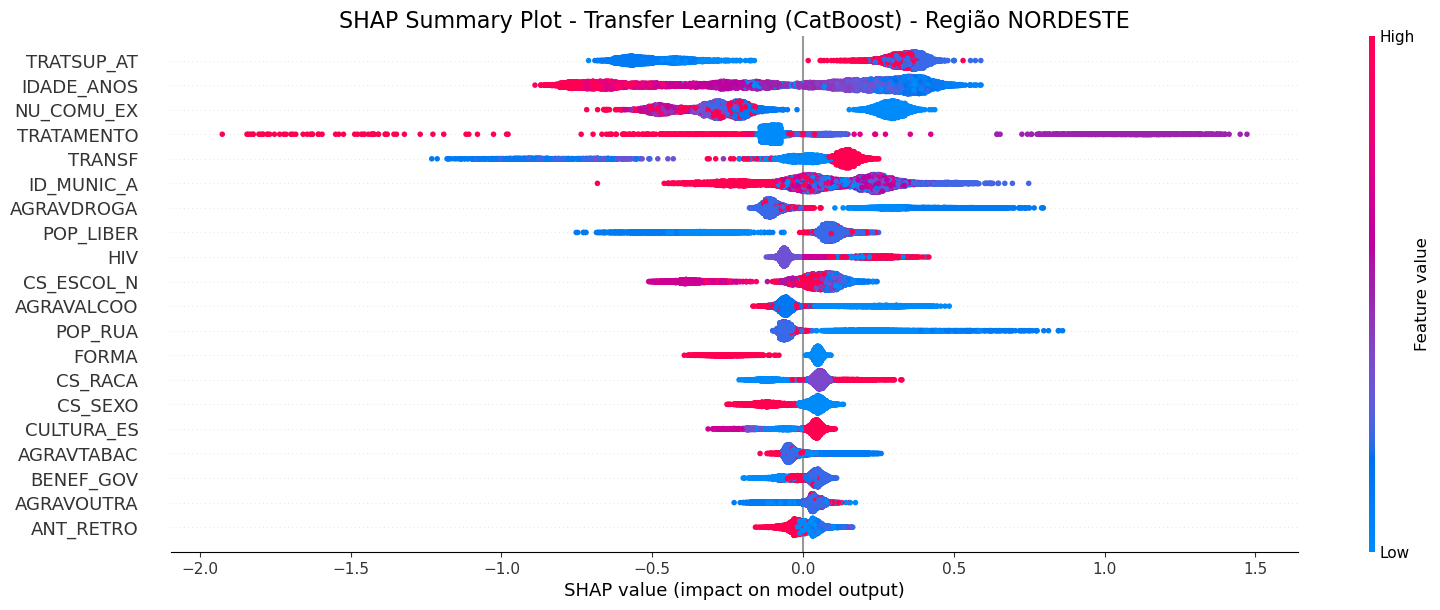


PROCESSANDO REGIÃO: NORTE
Buscando o melhor modelo no experimento 'Comparacao_Transfer_Learning_norte'...
Melhor execução encontrada: 'Transfer Learning' com AUC de 0.7519 (Run ID: 94656b1c0a5843b68c1c9bb24e4b2c62)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'norte'...
Gerando gráfico SHAP...


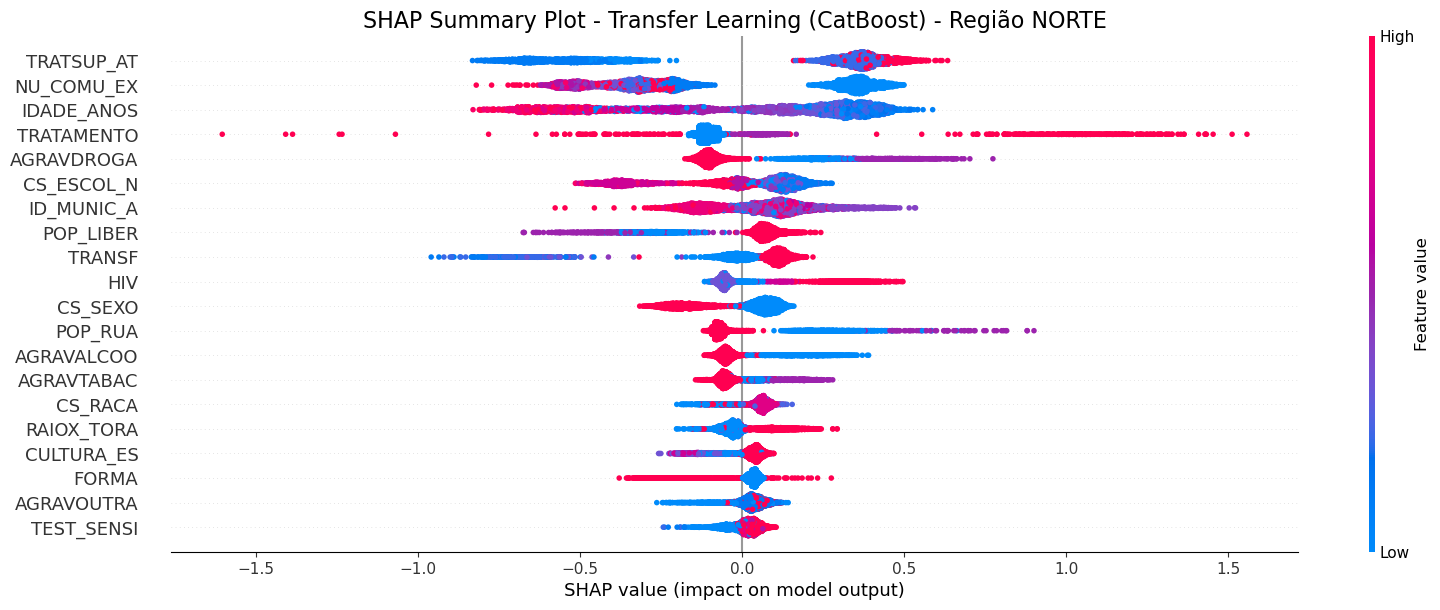


PROCESSANDO REGIÃO: CENTRO_OESTE
Buscando o melhor modelo no experimento 'Comparacao_Transfer_Learning_centro_oeste'...
Melhor execução encontrada: 'Transfer Learning' com AUC de 0.7646 (Run ID: d65c38901c754439bbeeba2206dc2c86)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'centro_oeste'...
Gerando gráfico SHAP...


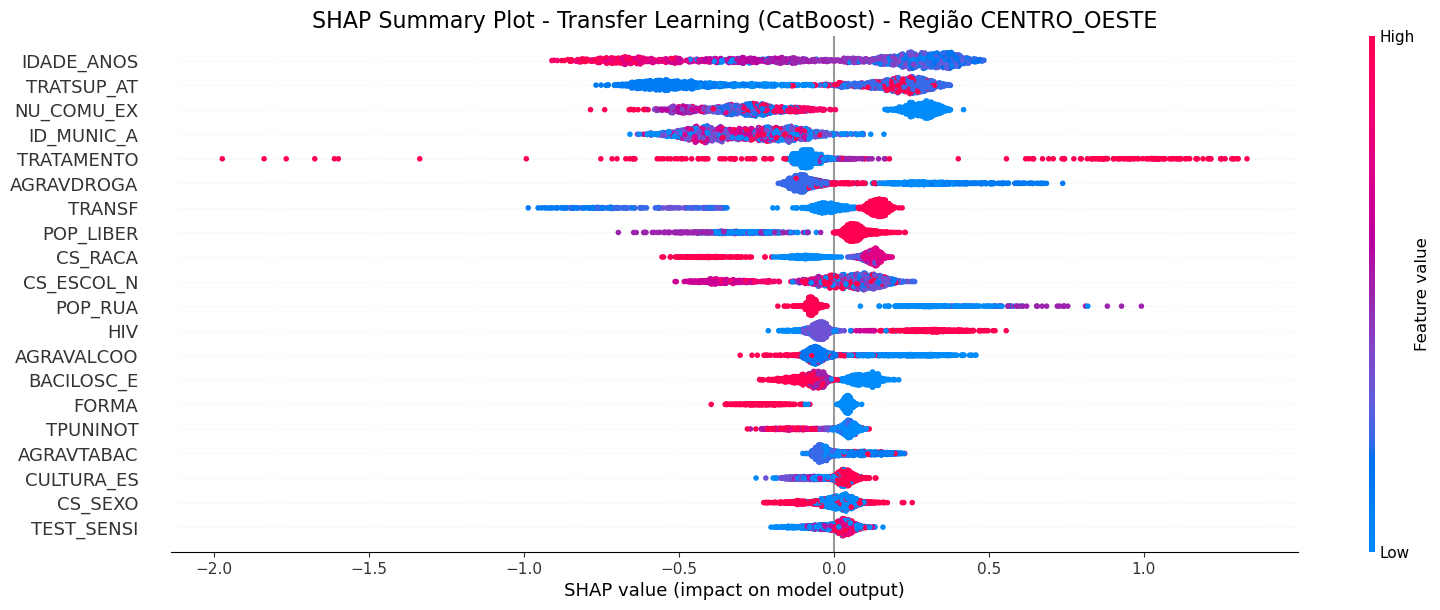


PROCESSANDO REGIÃO: SUL
Buscando o melhor modelo no experimento 'Comparacao_Transfer_Learning_sul'...
Melhor execução encontrada: 'Transfer Learning' com AUC de 0.7815 (Run ID: 4177a76bfd444209a2d8121b59409d40)


Modelo nativo (<class 'catboost.core.CatBoostClassifier'>) carregado com sucesso!
Carregando dados de teste para 'sul'...
Gerando gráfico SHAP...


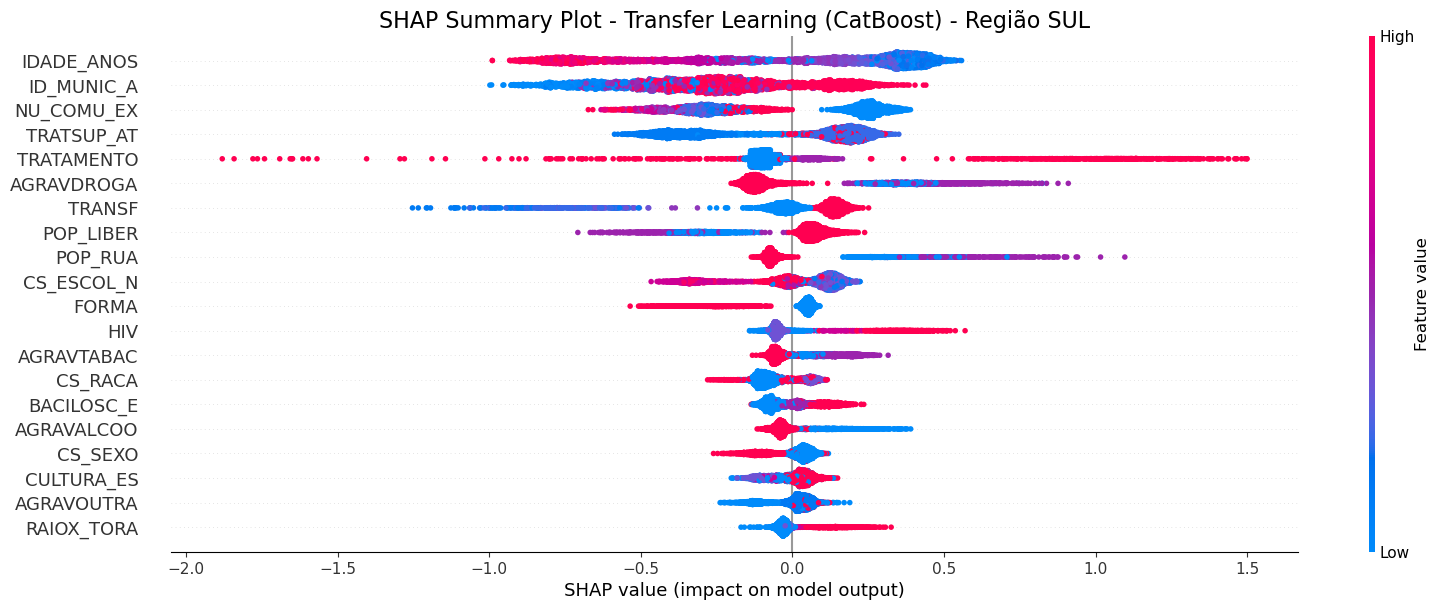


Análise SHAP para todas as regiões foi concluída.


In [ ]:
# O loop vai iterar sobre cada nome de região encontrado
for regiao in regioes_alvo:
    print(f"\n{'='*70}")
    print(f"PROCESSANDO REGIÃO: {regiao.upper()}")
    print(f"{'='*70}")
    
    # Bloco try/except para lidar com possíveis erros
    try:
        # 1. Definindo o experimento dinamicamente para a região atual
        # O nome do experimento deve ser o mesmo usado durante o LOG
        nome_do_experimento = f"Comparacao_Transfer_Learning_{regiao}" # Ajuste se o nome for outro

        # 2. Buscando as execuções e encontrando a melhor
        print(f"Buscando o melhor modelo no experimento '{nome_do_experimento}'...")
        runs_df = mlflow.search_runs(experiment_names=[nome_do_experimento], order_by=["metrics.AUC DESC"])
        
        if runs_df.empty:
            print(f"AVISO: Nenhum modelo encontrado para a região '{regiao}'. Pulando para a próxima.")
            continue
            
        best_run = runs_df.iloc[0]

        # --- CORREÇÃO 1: Pegar as tags corretas ---
        best_run_id = best_run.run_id
        # 'model_flavor' pega o tipo do modelo, ex: "CatBoost" (da tag "modelo")
        model_flavor = best_run["tags.modelo"] 
        # 'training_type' pega o tipo de treino, ex: "Transfer Learning" (da tag "tipo_treino")
        training_type = best_run["tags.tipo_treino"]
        model_auc = best_run["metrics.AUC"]
        
        print(f"Melhor execução encontrada: '{training_type}' com AUC de {model_auc:.4f} (Run ID: {best_run_id})")

        # --- CORREÇÃO 2: Determinar o caminho do artefato com base no tipo de treino ---
        # Estes devem ser os mesmos nomes usados em 'artifact_path' durante o mlflow.log_model
        if "Transfer Learning" in training_type:
            artifact_path = "modelo_tl"
        else:
            artifact_path = "modelo_scratch"

        # 4. Construindo a URI e carregando o modelo no seu "sabor" nativo
        # Usamos o 'artifact_path' correto na URI
        model_uri = f"runs:/{best_run_id}/{artifact_path}"
        
        # Usamos 'model_flavor' para chamar o getattr corretamente
        flavor_module = getattr(mlflow, model_flavor.lower())
        best_model_native = flavor_module.load_model(model_uri)
        print(f"Modelo nativo ({type(best_model_native)}) carregado com sucesso!")

        # 5. Carregando os dados de teste
        print(f"Carregando dados de teste para '{regiao}'...")
        X_test_regiao = dados[f'X_test_{regiao}']

        # 6. Gerando SHAP com título dinâmico
        print("Gerando gráfico SHAP...")
        explainer = shap.TreeExplainer(best_model_native)
        shap_values = explainer.shap_values(X_test_regiao)
        
        titulo_grafico = f"SHAP Summary Plot - {training_type} ({model_flavor}) - Região {regiao.upper()}"
        
        shap.summary_plot(shap_values, X_test_regiao, show=False, plot_size=(16, 6))
        plt.title(titulo_grafico, size=16)
        plt.show()

    except KeyError as e:
        print(f"ERRO: Chave não encontrada. Verifique se a tag ou os dados existem. Chave: {e}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao processar a região '{regiao}': {e}")

print(f"\n{'='*70}")
print("Análise SHAP para todas as regiões foi concluída.")
print(f"{'='*70}")

Juntar municípios em categorias maiores  
Coluna tratamento faz sentido?  
Como o catboost está tratando as variáveis? São numéricas ou categóricas?  

## Seleção de Variáveis - Boruta

In [38]:
dados['X_train_sudeste'].values.shape

(32141, 42)

In [39]:
dados['y_train_sudeste'].values.ravel().shape

(32141,)

In [49]:
#Criando um modelo Catboost em branco para o Boruta
params_best_model = {#'iterations': 500, #foi definido dentro do boruta
                    'learning_rate': 0.03,
                    'border_count': 32,
                    'depth': 7,
                    'l2_leaf_reg':10,
                    'verbose': 0,
                    'random_state': 42
        }

catboost_boruta = catboost.CatBoostClassifier(verbose=0)

# Configurando o Boruta.
boruta_selector = BorutaPy(estimator=catboost_boruta, 
                           n_estimators=500,
                           verbose=2,
                           random_state=42)

# Aplicando Boruta.
boruta_selector.fit(dados['X_train_sudeste'].values, dados['y_train_sudeste'].values.ravel())

ValueError: Please check your X and y variable. The provided estimator cannot be fitted to your data.
Object of type RandomState is not JSON serializable

In [50]:

# Supondo que a variável 'dados' com seus DataFrames já existe
X_train_sudeste = dados['X_train_sudeste']
y_train_sudeste = dados['y_train_sudeste']


# --- TESTE DE SANIDADE ---
# O objetivo é verificar a compatibilidade básica entre as bibliotecas.

print("--- Iniciando Teste de Sanidade ---")
print("Criando um CatBoost Classifier com parâmetros padrão (sem customização)...")

# 1. Criamos um CatBoost SEM NENHUM PARÂMETRO. Totalmente "vanilla".
vanilla_catboost = catboost.CatBoostClassifier(verbose=0)

# 2. Criamos o Boruta passando apenas o estimador e o random_state para reprodutibilidade.
#    Não definimos n_estimators nem nada mais.
vanilla_boruta_selector = BorutaPy(
    estimator=vanilla_catboost,
    random_state=42,
    verbose=2
)

try:
    print("\nTentando executar o .fit() do Boruta com a configuração mínima...")
    # 3. Tentamos executar o fit.
    vanilla_boruta_selector.fit(X_train_sudeste.values, y_train_sudeste.values.ravel())
    
    print("\n-------------------------------------------")
    print(">>> TESTE DE SANIDADE CONCLUÍDO COM SUCESSO! <<<")
    print("-------------------------------------------")
    print("Isso indica que a incompatibilidade está nos parâmetros específicos que estávamos tentando passar.")

except Exception as e:
    print("\n------------------------------------")
    print(">>> TESTE DE SANIDADE FALHOU. <<<")
    print("------------------------------------")
    print("Isso confirma que há uma incompatibilidade fundamental entre as versões das bibliotecas.")
    print("\nO erro recebido foi:")
    print(e)

--- Iniciando Teste de Sanidade ---
Criando um CatBoost Classifier com parâmetros padrão (sem customização)...

Tentando executar o .fit() do Boruta com a configuração mínima...

------------------------------------
>>> TESTE DE SANIDADE FALHOU. <<<
------------------------------------
Isso confirma que há uma incompatibilidade fundamental entre as versões das bibliotecas.

O erro recebido foi:
Please check your X and y variable. The provided estimator cannot be fitted to your data.
Object of type RandomState is not JSON serializable


In [57]:
import boruta

'boruta'

## Visualizando as Árvores Iniciais

Preciso instalar o graphviz 

In [41]:
print(f"Modelo fonte tem {best_model_native.tree_count_} árvores")

Modelo fonte tem 500 árvores


## Visualizando as Árvoeres em JSON

In [21]:
nome_arquivo_json = 'estrutura_modelo_catboost.json'

best_model_native.dump_model(
    out_file=nome_arquivo_json,
    format='json'
)


AttributeError: 'CatBoostClassifier' object has no attribute 'dump_model'